c:\Users\USER 1\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Forest F1-score: 0.76
XGBoost F1-score: 0.75


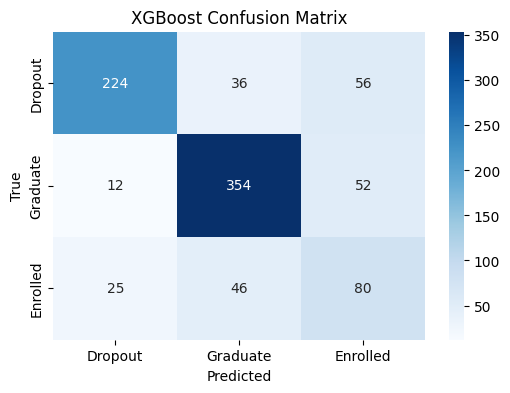

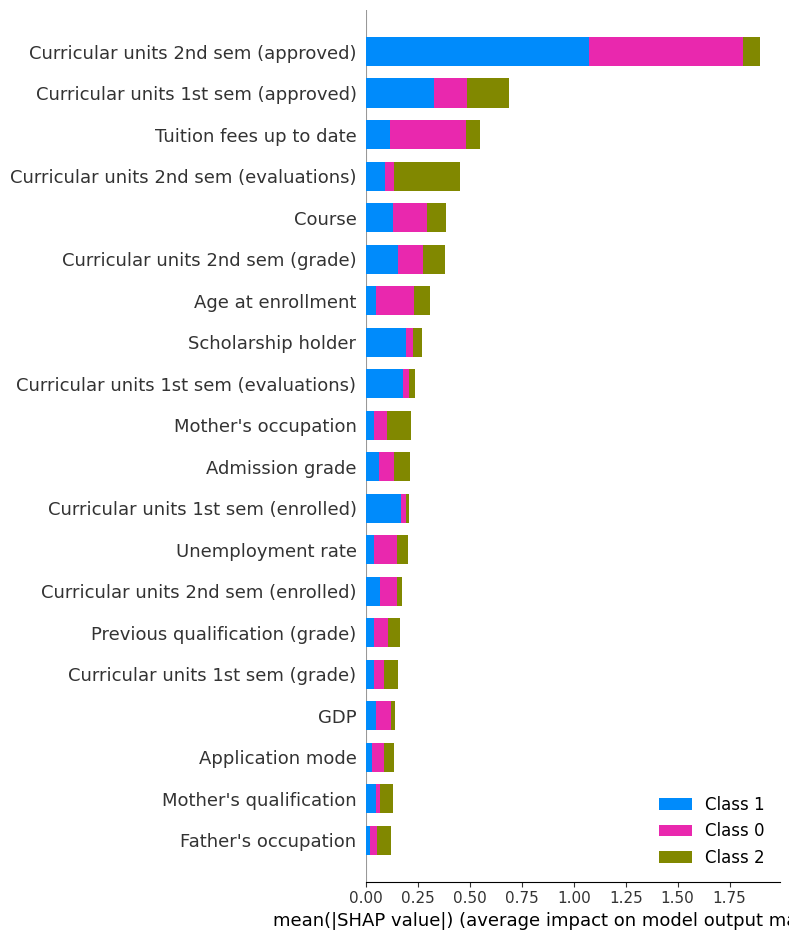

Top 5 Features by Importance:
                                   Feature  Importance
30     Curricular units 2nd sem (approved)    1.898227
24     Curricular units 1st sem (approved)    0.689625
16                 Tuition fees up to date    0.549603
29  Curricular units 2nd sem (evaluations)    0.453823
3                                   Course    0.385235
Model training, plots, and data saved successfully!


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
from sklearn.utils.class_weight import compute_class_weight
from lime import lime_tabular
import joblib

# Load the data (ensure data.csv is in the same directory)
data = pd.read_csv('data.csv', sep=';')

# Prepare features and target
target_mapping = {'Dropout': 0, 'Graduate': 1, 'Enrolled': 2}
y = data['Target'].map(target_mapping)
X = data.drop('Target', axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest with tuned hyperparameters
rf = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# XGBoost with tuned hyperparameters and class weighting
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_train)
sample_weights = [class_weights[label] for label in y_train]

xgb = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42)
xgb.fit(X_train, y_train, sample_weight=sample_weights)
xgb_pred = xgb.predict(X_test)

# Evaluate performance
print(f"Random Forest F1-score: {f1_score(y_test, rf_pred, average='weighted'):.2f}")
print(f"XGBoost F1-score: {f1_score(y_test, xgb_pred, average='weighted'):.2f}")

# Visualize XGBoost results with a confusion matrix
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Dropout', 'Graduate', 'Enrolled'], 
            yticklabels=['Dropout', 'Graduate', 'Enrolled'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Feature importance with SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap_values_agg = np.mean(np.abs(shap_values), axis=0)
shap_values_total = np.sum(shap_values_agg, axis=1)
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.savefig('shap_plot.png')
plt.close()
print("Top 5 Features by Importance:")
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': shap_values_total})
print(feature_importance.sort_values('Importance', ascending=False).head())

# Local explanation with LIME
lime_explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', 
                                                  feature_names=X.columns, class_names=['Dropout', 'Graduate', 'Enrolled'])
lime_exp = lime_explainer.explain_instance(X_test.iloc[0].values, xgb.predict_proba, num_features=5)
lime_exp.save_to_file('lime_plot.png')

# Save model and data for dashboard use
joblib.dump(xgb, 'xgb_model.joblib')
feature_importance.to_csv('feature_importance.csv', index=False)
np.save('cm.npy', cm)
np.save('y_test.npy', y_test)
np.save('xgb_pred.npy', xgb_pred)

print("Model training, plots, and data saved successfully!")

In [ ]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report
model= joblib.load('xgb_model.joblib')

In [6]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('data.csv', sep=';', index_col=None)
data.head()
target_mapping = {'Dropout': 0, 'Graduate': 1, 'Enrolled': 2}
y = data['Target'].map(target_mapping)
X = data.drop('Target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Dropout', 'Graduate', 'Enrolled']))


              precision    recall  f1-score   support

     Dropout       0.86      0.71      0.78       316
    Graduate       0.81      0.85      0.83       418
    Enrolled       0.43      0.53      0.47       151

    accuracy                           0.74       885
   macro avg       0.70      0.70      0.69       885
weighted avg       0.76      0.74      0.75       885



In [7]:
import pandas as pd

# load the file
df = pd.read_csv("feature_importance.csv")

# see the raw columns
print("raw columns:", df.columns.tolist())

# peek at first column
print(repr(df.columns[0]))


raw columns: ['Feature', 'Importance']
'Feature'


In [8]:
import xlsxwriter
print("xlsxwriter is installed!")

xlsxwriter is installed!


In [9]:
import joblib

# Load the model
model = joblib.load('xgb_model.joblib')
# Check if feature names are directly available
if hasattr(model, 'feature_names'):
    print("Model feature names:", model.feature_names)
else:
    print("Feature names not directly stored in the model. Check training data.")

Feature names not directly stored in the model. Check training data.


In [10]:
import pandas as pd

# Load the original dataset (adjust path and separator as needed)
data = pd.read_csv('data.csv', sep=';')  # Match your file format
X = data.drop('Target', axis=1)  # Assuming 'Target' is the label column
feature_names = X.columns.tolist()
print("Training feature names:", feature_names)

Training feature names: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP

In [11]:
# Import required libraries for LIME
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Feature names and class names
feature_names = X.columns.tolist()
class_names = ['Dropout', 'Graduate', 'Enrolled']

# Select a sample instance to explain (e.g., the first row of test data)
sample_instance = X_test.iloc[0].values

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# Generate explanation for the sample instance
exp = explainer.explain_instance(
    sample_instance,
    model.predict_proba,
    num_features=6  # Top 6 features for clarity
)

# Save the explanation as an image
exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig('lime_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

print("LIME explanation image 'lime_analysis.png' has been generated.")

LIME explanation image 'lime_analysis.png' has been generated.
